In [9]:
import torch
from torch.nn import Linear
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import random_split, DataLoader, Dataset
import os
import gzip
import json
import random
import numpy as np

In [5]:
from sklearn.datasets import fetch_openml

mnist = fetch_openml("mnist_784", version=1, return_X_y=True, as_frame=False)
X, y = mnist

# Define the sizes for the train, validation, and test sets
train_size = 50000
val_size = 10000

# Split the dataset into train, validation, and test sets
X_train, X_remaining = X[:train_size], X[train_size:]
y_train, y_remaining = y[:train_size], y[train_size:]

X_val, X_test = X_remaining[:val_size], X_remaining[val_size:]
y_val, y_test = y_remaining[:val_size], y_remaining[val_size:]
train_set = [X_train, y_train]
val_set = [X_val, y_val]
test_set = [X_test, y_test]

original_data=[train_set,val_set,test_set]

# Print shapes of the resulting datasets
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_val shape:", X_val.shape)
print("y_val shape:", y_val.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)


/usr/local/lib/python3.11/site-packages/sklearn/datasets/_openml.py:968: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


X_train shape: (50000, 784)
y_train shape: (50000,)
X_val shape: (10000, 784)
y_val shape: (10000,)
X_test shape: (10000, 784)
y_test shape: (10000,)


In [6]:
imgs,labels=train_set[0], train_set[1]
print("Number of train set: ", len(imgs))

imgs_length=len(imgs)
index_list=list(range(imgs_length))

#random shuffle index 
random.shuffle(index_list)
batch_size=100
#define data generator

def data_generator():
    imgs_list=[]
    labels_list=[]
    for i in index_list:
        #change data into numpy
        img=np.array(imgs[i]).astype('float32')
        label=np.array(labels[i]).astype('float32')
        imgs_list.append(img)
        labels_list.append(label)
        if len(imgs_list)==batch_size:
            #get a batchsize and return
            yield np.array(imgs_list), np.array(labels_list)

            #empty the list and redo batch again
            imgs_list=[]
            labels_list=[]

    #if the remain data number less than batchsize
    #get a mini-batch
    if len(imgs_list)>0:
        yield np.array(imgs_list), np.array(labels_list)
    return data_generator

Number of train set:  50000


The yield keyword is used in a function to create a generator. A generator is a special type of iterator that allows you to iterate over a sequence of values without creating the entire sequence in memory. Instead, generators produce the values one at a time, on-the-fly, as you request them by iterating over the generator.

The yield statement is used to return a value from the generator function and temporarily suspend its execution. The next time the generator is iterated, it resumes execution right after the yield statement, retaining its previous state, including local variables and execution context.

In [7]:
#load traindata
train_loader=data_generator

for batch_id, data in enumerate(train_loader()):
    image_data,label_data=data
    if batch_id==0:
        print("打印第一个batch数据的维度,以及数据类型:")
        print("图像维度: {}, 标签维度: {},图像数据类型{}, 标签数据类型{}".format(image_data.shape, label_data.shape,type(image_data),type(label_data)))
    break

打印第一个batch数据的维度,以及数据类型:
图像维度: (100, 784), 标签维度: (100,),图像数据类型<class 'numpy.ndarray'>, 标签数据类型<class 'numpy.ndarray'>


In [8]:
#valadation 
#机器校验：加入一些校验和清理数据的操作。
#人工校验：先打印数据输出结果，观察是否是设置的格式。再从训练的结果验证数据处理和读取的有效性。
imgs_length = len(imgs)
assert len(imgs) == len(labels), \
        "length of train_imgs({}) should be the same as train_labels({})".format(len(imgs), len(labels))

In [9]:
#pack load data
def load_data(mode="train"):
    if mode=='train':
        imgs,labels=train_set[0],train_set[1]
    elif mode=='valid':
        imgs,labels=val_set[0],val_set[1]
    elif mode=='test':
        imgs,labels=test_set[0],test_set[1]
    else:
        raise Exception( "mode can only be one of ['train', 'valid', 'test']" )
    print("number of the dataset", len(imgs))

    #check shuffle
    imgs_length=len(imgs)
    assert len(imgs)==len(labels), \
          "length of train_imgs({}) should be the same as train_labels({})".format(len(imgs), len(labels))
    

    #shuffle
    #define the index
    index_list=list(range(imgs_length))
    batch_size=100

    def data_generator():
        if mode=='train':
            random.shuffle(index_list)
        imgs_list=[]
        labels_list=[]
        for i in index_list:
            #don't forget the normalization of images
            img=np.array(imgs[i]).astype('float32')/255
            label=np.array(labels[i]).astype('float32')
            imgs_list.append(img)
            labels_list.append(label)

            if len(imgs_list)==batch_size:
                yield np.array(imgs_list),np.array(labels_list)
                imgs_list=[]
                labels_list=[]

        if len(imgs_list)>0:
            yield np.array(imgs_list), np.array(labels_list)
    return data_generator


In [10]:
class MNIST(torch.nn.Module):
    def __init__(self):
        super(MNIST,self).__init__()
        self.fc=torch.nn.Linear(in_features=784,out_features=1)

    def forward(self,inputs):
        outputs=self.fc(inputs)
        return outputs

In [11]:
def train(model):
    model=MNIST()
    model.train()
    train_loader=load_data('train')
    optimizer=torch.optim.SGD(model.parameters(),lr=0.001)
    epoch_num=10
    for epoch in range(epoch_num):
        for batch, data in enumerate(train_loader()):
            images,labels=data
            images=torch.from_numpy(images)
            labels=torch.from_numpy(labels)

            predicts=model(images)

            loss=F.mse_loss(predicts,labels)
            avg_loss=torch.mean(loss)
            if batch % 200 ==0:
                print('epoch: {},batch: {}, loss is: {}'.format(epoch,batch,avg_loss))

            avg_loss.backward()
            optimizer.step()
            optimizer.zero_grad()

    torch.save(model.state_dict(),'mnist.pth')

In [12]:
model=MNIST()
train(model)

number of the dataset 50000
epoch: 0,batch: 0, loss is: 30.331802368164062


/var/folders/rz/cvwxv_893p7cj9rn8qdyqxlc0000gn/T/ipykernel_53430/2022379986.py:15: UserWarning: Using a target size (torch.Size([100])) that is different to the input size (torch.Size([100, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss=F.mse_loss(predicts,labels)


epoch: 0,batch: 200, loss is: 9.318705558776855
epoch: 0,batch: 400, loss is: 9.835793495178223
epoch: 1,batch: 0, loss is: 8.741619110107422
epoch: 1,batch: 200, loss is: 8.77681827545166
epoch: 1,batch: 400, loss is: 8.861865043640137
epoch: 2,batch: 0, loss is: 8.994017601013184
epoch: 2,batch: 200, loss is: 8.84766674041748
epoch: 2,batch: 400, loss is: 9.263908386230469
epoch: 3,batch: 0, loss is: 9.576977729797363
epoch: 3,batch: 200, loss is: 8.399606704711914
epoch: 3,batch: 400, loss is: 8.105779647827148
epoch: 4,batch: 0, loss is: 8.178569793701172
epoch: 4,batch: 200, loss is: 9.53740119934082
epoch: 4,batch: 400, loss is: 10.157859802246094
epoch: 5,batch: 0, loss is: 9.644535064697266
epoch: 5,batch: 200, loss is: 8.814888954162598
epoch: 5,batch: 400, loss is: 7.527480602264404
epoch: 6,batch: 0, loss is: 8.687040328979492
epoch: 6,batch: 200, loss is: 8.023115158081055
epoch: 6,batch: 400, loss is: 7.8401408195495605
epoch: 7,batch: 0, loss is: 9.218419075012207
epoch: 

In [92]:
transform=transforms.Normalize(mean=[0.5],std=[0.5])

class MNISTData(Dataset):
    """
    Step 1: Inherit the torch.utils.data.Dataset class
    """
    def __init__(self,data,mode='train',transform=None):
        super().__init__()
        self.mode=mode
        self.transform=transform
        #seperate train val eval
        train_set, val_set, test_set=data

        if mode=='train':
            self.imgs,self.labels=train_set[0],train_set[1]
        elif mode=='valid':
            self.imgs,self.labels=val_set[0],val_set[1]
        elif mode=='test':
            self.imgs,self.labels=test_set[0],test_set[1]
        else:
            raise Exception( "mode can only be one of ['train', 'valid', 'test']" )
        
    def __getitem__(self,index):
        """
        Step 3: Implement the __getitem__ method, define how to get data when specifying an index
        """
        data=self.imgs[index]
        label=int(self.labels[index])

        if self.transform:
            data=torch.tensor(data,dtype=torch.float).view(1,28,28)
            data=self.transform(data)
        
        label=torch.tensor(label,dtype=torch.float)

        return data, label
    
    def __len__(self):
        """
        Step 4: Implement the __len__ method, return the total number of the dataset
        """
        return len(self.imgs)
    
    

In [93]:
#get data
train_dataset=MNISTData(original_data,mode='train',transform=transform)
test_dataset=MNISTData(original_data,mode='test',transform=transform)

print('train images: ', train_dataset.__len__(), 'test images: ', test_dataset.__len__())


train images:  50000 test images:  10000


shape of image:  torch.Size([1, 28, 28])


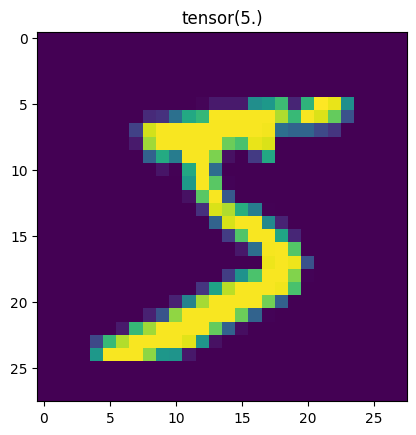

In [94]:
from matplotlib import pyplot as plt

for data in train_dataset:
    images,labels=data
    print('shape of image: ', images.shape)
    plt.title(str(labels))
    plt.imshow(images[0])
    break

* torch.utils.data.Dataset is an abstract base class representing a dataset. It provides a standardized interface for managing data, including retrieving data samples and their corresponding labels. When you create a custom dataset, you should inherit from this class and implement the __getitem__() and __len__() methods. The __getitem__() method defines how to access a single data point (or sample) from the dataset, while the __len__() method returns the total number of samples in the dataset.

* torch.utils.data.DataLoader is a utility class that wraps a Dataset object and provides an iterator to efficiently load data in parallel, manage batching, shuffling, and other data manipulation tasks. It takes a Dataset object as input, along with other optional parameters such as batch_size, shuffle, num_workers, and collate_fn. The DataLoader simplifies the process of feeding data to a model during training and evaluation.

* The relationship between Dataset and DataLoader is that Dataset is responsible for managing the data and providing a standardized interface for accessing individual samples, while DataLoader is responsible for handling efficient data loading, batching, and other data manipulation tasks. You pass a Dataset object to a DataLoader to create an iterable that can be used in your training and evaluation loops.

In [121]:
train_loader=DataLoader(train_dataset,batch_size=64,shuffle=True,drop_last=True)
print('step num ', len(train_loader))

step num  781


通过上述方法，初始化了一个数据读取器 train_loader，用于加载训练数据集。在数据读取器中几个常用的字段如下：

- batch_size：每批次读取样本数，示例中 batch_size=64 表示每批次读取 64 个样本。
- shuffle：样本乱序，示例中 shuffle=True 表示在取数据时打乱样本顺序，以减少过拟合发生的可能。
- drop_last：丢弃不完整的批次样本，示例中 drop_last=True 表示丢弃因数据集样本数不能被 batch_size 整除而产生的最后一个不完整的 batch 样本。
- num_workers：同步/异步读取数据，通过 num_workers 来设置加载数据的子进程个数，num_workers的值设为大于0时，即开启多进程方式异步加载数据，可提升数据读取速度。

In [126]:
def train(mode):
    print('train:')
    model.train()
    optimizer=torch.optim.SGD(model.parameters(), lr=0.001)
    epoch_num=3
    for epoch in range(epoch_num):
        print('Epoch: ', epoch)
        for batch, data in enumerate(train_loader):
            images,labels=data
            images=images.to(torch.float32)
            #labels=labels.unsqueeze(1)
            labels=labels.to(torch.float32)
            images=torch.reshape(images, [images.shape[0], images.shape[2]*images.shape[3]])
            optimizer.zero_grad()

            predicts=model(images)

            loss=F.mse_loss(predicts,labels)
            avg_loss=torch.mean(loss)

            if batch%200==0:
                print('epoch {}, batch {}, loss is: {}'.format(epoch, batch, avg_loss))

            avg_loss.backward()
            optimizer.step()
            
    
    torch.save(model.state_dict(),'mnistloader.pth')

print('create model:')
model=MNIST()
train(model)


create model:
train:
Epoch:  0
epoch 0, batch 0, loss is: 28.018875122070312


/var/folders/rz/cvwxv_893p7cj9rn8qdyqxlc0000gn/T/ipykernel_53430/1681703384.py:19: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss=F.mse_loss(predicts,labels)


epoch 0, batch 200, loss is: 8.326987266540527
epoch 0, batch 400, loss is: 8.990245819091797
epoch 0, batch 600, loss is: 9.548530578613281


/var/folders/rz/cvwxv_893p7cj9rn8qdyqxlc0000gn/T/ipykernel_53430/1681703384.py:19: UserWarning: Using a target size (torch.Size([16])) that is different to the input size (torch.Size([16, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss=F.mse_loss(predicts,labels)


Epoch:  1
epoch 1, batch 0, loss is: 9.476701736450195
epoch 1, batch 200, loss is: 8.961752891540527
epoch 1, batch 400, loss is: 10.291584968566895
epoch 1, batch 600, loss is: 10.397298812866211
Epoch:  2
epoch 2, batch 0, loss is: 9.617834091186523
epoch 2, batch 200, loss is: 7.5260443687438965
epoch 2, batch 400, loss is: 8.223013877868652
epoch 2, batch 600, loss is: 9.574507713317871


In [123]:
#data loader by pytorch
#torch function
transform=transforms.ToTensor()
mnist_train=torchvision.datasets.MNIST(root='/Users/isabelleliu/Desktop/code practice',train=True, download=False, transform=transform)
mnist_test=torchvision.datasets.MNIST(root='/Users/isabelleliu/Desktop/code practice',train=False, download=False, transform=transform)

#split train into train and validation
train_set, val_set=random_split(mnist_train,[len(mnist_train)-10000,10000])
batch_size=64

#create dataloader use default function
train_loader=DataLoader(train_set,batch_size,shuffle=True)
val_loader=DataLoader(val_set,batch_size,shuffle=True)
test_loader=DataLoader(mnist_test,batch_size,shuffle=True)



In [2]:
import torch
import torchvision.transforms.functional as TF
from PIL import Image

img_path = "head.png"

image = Image.open(img_path)

# adjust_brightness对输入图像进行亮度值调整
new_img = TF.adjust_brightness(image, 0.4)

# 显示图像
image.show()
new_img.show()

In [11]:
new_img = TF.adjust_hue(image, hue_factor=0.5)

# 显示图像
image.show()
new_img.show()

In [ ]:
# # adjust_hue对输入图像进行色调的调整
transform = transforms.RandomRotation(degrees=(-90,90))
new_img = transform(image)

# 显示图像
image.show()
new_img.show()

* from torchvision.transforms import Resize
    - transform = Resize((256, 256))

* from torchvision.transforms import RandomCrop
    - transform = RandomCrop((224, 224))

* from torchvision.transforms import RandomHorizontalFlip
    - transform = RandomHorizontalFlip(p=0.5)

* from torchvision.transforms import ColorJitter
    - transform = ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1)

* from torchvision.transforms.functional import rotate
    - new_img = rotate(image, degrees=45)

* from torchvision.transforms.functional import adjust_hue
    - new_img = adjust_hue(image, hue_factor=0.5)

* from torchvision.transforms.functional import adjust_brightness
    - new_img = adjust_brightness(image, brightness_factor=0.5)